In [37]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

In this notebook we implement three versions of gradient descent w/ linear regression: batch, regularized and stochastic. First a theoretic discussion about the square loss function which we will be using: it has the Bayes Optimal Predictor of the form $g(x) = \boldsymbol{E}[Y|X=x]$, which achieves the minimal risk among all possible hypothesis functions. 

Specifically, for data, target pair $(x, y)$ drawn i.i.d. from $P_{X,Y}(x,y)$, $R(f)$ the expected loss of a decision function $f$ where $R(f) = \boldsymbol{E} \left( l(f(x), y) \right)$ , we show $g$ has the property that $R(g) = \inf_f R(f)$. 

Given the hypothesis function $g: X \rightarrow Y$ and square loss function $l(g, (x,y)) = \frac{1}{2}\left(g(x) - y\right)^2$:

\begin{align*}
\boldsymbol{E}\left(\frac{1}{2}(Y - g(X))^2 \right) & = \frac{1}{2} \boldsymbol{E}\left( \left( Y - \boldsymbol{E} \left( Y |X \right) + \boldsymbol{E} \left( Y |X \right) - g(X)\right)^2 \right) \\
 & = \frac{1}{2} \boldsymbol{E}\left( \boldsymbol{E} \left( Y - \boldsymbol{E} \left( Y |X \right) + \boldsymbol{E} \left( Y |X \right) - g(X)\right)^2 | X \right) \text{ By Law of Total Expectation}\\
 & = \frac{1}{2} \boldsymbol{E} \left(  \text{Var}(Y|X) \right) +  \boldsymbol{E} \left( \boldsymbol{E}(Y|X) - g(X) \right) ^2
\end{align*}

Since $g(x) = \boldsymbol{E}(Y|X = x)$, set the last line above to be conditioned by the deterministic variable $X = x$. Only the expectation of variance $\boldsymbol{E}\left(\text{Var}(Y|X=x)\right) $ remains, which is the irreducible error w.r.t. sample $x$. No other hypothesis function $f \in F$ can achieve a lower expected loss, as was claimed.

In [38]:
dummy = np.array([[1, 1, 1],[2, 2, 2],[3, 3, 3]], dtype=float)
file = 'hw1-data.csv'
df = pd.read_csv(file, delimiter=',')
X = df.values[:,:-1]
y = df.values[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 100, random_state=10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(100, 48) (100,) (100, 48) (100,)


In [39]:
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size (num_instances, num_features)
        test  - test set, a 2D numpy array of size (num_instances, num_features)
    Returns:
        train_normalized - training set after normalization
        test_normalized  - test set after normalization
    """
    for col in range(train.shape[1]):
        minimum = np.nanmin(train[:,col])
        train[:, col] -= minimum
        test[:, col] -= minimum
        
        max_ = np.nanmax(train[:,col])
        train[:,col] /= max_
        test[:,col] /= max_
        
    return train, test

In [40]:
X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)))) # Add bias term

In [41]:
theta = np.full(49, fill_value= 0.05, dtype=np.float)

def compute_square_loss(theta, X, y):
    """
    Given a set of X, y, theta, compute the square loss for predicting y with X*theta
    Args:
        feature - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)
    Returns:
        loss - the square loss, scalar
    """
    pred = np.dot(theta, X.T)
    return ((sum((pred-y)**2))/(2*X.shape[0]))

print(compute_square_loss(theta, X_train, y_train))

4.76289096941


In [42]:
def compute_square_loss_gradient(theta, X, y):
    """
    Compute gradient of the square loss (as defined in compute_square_loss), at the point theta.
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    pred = np.dot(X, theta)
    residual = (pred-y)
       
    return np.dot(residual, X)/(X.shape[0])

compute_square_loss_gradient(theta, X_train, y_train)

array([ 1.42312141,  1.20784156,  1.06010688,  1.0060222 ,  1.16929782,
        1.12295754,  1.05182574,  1.05182574,  0.88995025,  0.69762374,
        0.58760797,  0.68601255,  0.72082546,  0.71605806,  0.1185265 ,
        0.0276565 , -0.01169991, -0.01050249,  1.07864942,  1.07864942,
        1.07864942,  0.9601701 ,  0.9601701 ,  0.9601701 ,  0.87358328,
        0.87358328,  0.87358328,  0.83351942,  0.83351942,  0.83351942,
        0.81130774,  0.81130774,  0.81130774,  0.45431484,  0.45431484,
        0.45431484,  0.56469082,  0.56469082,  0.56469082,  0.64712795,
        0.64712795,  0.64712795,  0.68474379,  0.68474379,  0.68474379,
        0.70544184,  0.70544184,  0.70544184,  1.48750273])

In [43]:
def unit_vec(num_features):
    z = np.zeros(num_features-1)
    for i in range(num_features):
        yield np.insert(z, i, 1)

def grad_checker(theta, X, y,  epsilon=0.01, tolerance=1e-4): 
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions: 
    (e_1 = (1,0,0,...,0), e_2 = (0,1,0,...,0), ..., e_d = (0,...,0,1) 

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by: 
    ( J(theta + epsilon * e_i) - J(theta - epsilon * e_i) ) / (2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error
    
    Return:
        A boolean value indicate whether the gradient is correct or not
    """
    true_gradient = compute_square_loss_gradient(theta, X, y) 
    num_features = theta.shape[0]
    
    approx_grad = []
    for u in unit_vec(num_features):
        approx_grad.append((compute_square_loss(theta+epsilon*u, X, y) - 
                             compute_square_loss(theta-epsilon*u, X, y))/(2*epsilon))
        
    difference = np.linalg.norm(np.array(approx_grad)-true_gradient)
    correct =  difference <= tolerance 
    if not correct:
        print(correct, difference)
        raise Exception('incorrect gradient')
        
    return difference

grad_checker(theta, X_train, y_train)

4.9466552380911437e-13

In [44]:
def unit_vec(num_features):
    z = np.zeros(num_features-1)
    for i in range(num_features):
        yield np.insert(z, i, 1)

def f(*args):
    args = list(args)
    theta = args[2]
    num_features = theta.shape[0]
    
    obj_func = args[1]
    X = args[3]
    y = args[4]
    epsilon = args[5]
    L = args[6]
    approx_grad = []
    for u in unit_vec(num_features):
        
        try:
            approx_grad.append((obj_func(theta+epsilon*u, X, y) 
                                - obj_func(theta-epsilon*u, X, y))/(2*epsilon))
        except:
            approx_grad.append((obj_func(theta+epsilon*u, X, y, L) 
                                - obj_func(theta-epsilon*u, X, y, L))/(2*epsilon))
    try:
        true_g = args[0](theta, X, y)
    except:
        true_g = args[0](theta, X, y, L)
    
    tolerance = args[6]
    
    difference = np.linalg.norm(np.array(approx_grad)-true_g)
    correct =  difference <= tolerance
    
    if not correct:
        print(correct, difference)
        raise Exception('incorrect gradient')
    return difference

def gen_grad_checker(f1, f2):
    epsilon = 0.01
    tolerance = 1e-4
    L = 0.5
    return f(f1, f2, theta, X_train, y_train,  epsilon, tolerance, L)

gen_grad_checker(compute_square_loss_gradient, compute_square_loss)

4.9466552380911437e-13

Linear Regression 

$J(\theta)  = \frac{1}{2m} \sum ^m _{i=1} (h_\theta(x_i) - y_i)^2$

In [45]:
def backtrack_line_search(fx, gradient, X, y, theta, alpha):
    tau = 0.5
    c = 0.5
    p = -gradient
    m = np.dot(p, gradient)
    t = c*m
    
    step = (compute_square_loss((theta.T + alpha*p).flatten(), X, y))
    #print(step, loss, alpha*t)
    
    #  Armijo-Goldstein cond: f(x) - f(x+ alpha_j * p) >= alpha_j * t
    while step- fx > alpha*t :
        alpha *= tau
        step = (compute_square_loss((theta.T + alpha*p).flatten(), X, y))
        
    return alpha

def batch_grad_descent(X, y, alpha=0.1, num_iter=1000, check_gradient=False, l_search = True):

    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist

    theta = np.ones(num_features) #initialize theta
    
    a_hist = [alpha]
    
    for i in range(num_iter):
        
        loss = compute_square_loss(theta, X, y)
        if i != 0 and loss >= loss_hist[i-1]:
            #print(a_hist)
            return(loss_hist[0:i], theta_hist[0:i,:])
    
        loss_hist[i] = loss
        
        gradient = compute_square_loss_gradient(theta, X, y)
        if check_gradient:
            #grad_checker(theta, X, y)
            gen_grad_checker(compute_square_loss_gradient, compute_square_loss)
        if l_search:
            alpha= backtrack_line_search(loss, gradient, X, y, theta, alpha)
            a_hist.append(round(alpha,4))
        
        theta -= alpha*gradient
        theta_hist[i,:] = theta
        
    return loss_hist, theta_hist

loss_hist, theta_hist = batch_grad_descent(X_train, y_train, alpha = 50)

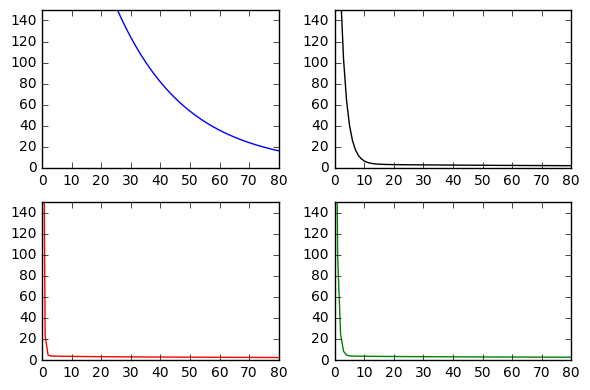

In [46]:
def alpha_graph(X, y, regularized = False):
    l = []
    for size in [0.1, 0.09, 0.04, 0.027]:
        if regularized:
            output = regularized_grad_descent(X, y, alpha = size, l_search = False)
        else:
            output = batch_grad_descent(X, y, alpha = size, l_search = False)
        #loss_hist, theta_hist = p
        l.append(output[0])
    c = ['b', 'k', 'r',  'g'] 
    s = [221+i for i in range(len(l))]
    fig = plt.figure()

    for i in range(len(l)):
        ax = fig.add_subplot(s[i])
        ax.set_ylim([0, 150])
        ax.set_xlim([0, 80])#len(l[i])])
        ax.plot(l[i], c[i])
    
    #for i in range(4):
    #    print([ '%.2f' % elem for elem in l[i] ])
    
    plt.tight_layout()
    plt.show()

alpha_graph(X_train, y_train, regularized = False)

Ridge Regression (Linear Regression with $L_2$ regularization) 

$J(\theta)  = \frac{1}{2m} \sum ^m _{i=1} (h_\theta(x_i) - y_i)^2 + \lambda \theta^T \theta$

In [47]:
def r_sq_loss(theta, X, y, lambda_reg):
    return compute_square_loss(theta, X,y) + lambda_reg*np.dot(theta.T, theta)

def compute_regularized_square_loss_gradient(theta, X, y, lambda_reg):
    """
    Compute the gradient of L2-regularized square loss function given X, y and theta
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        lambda_reg - the regularization coefficient
    
    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    pred = np.dot(X, theta)
    
    loss = pred-y 
    
    return np.dot(loss, X )/X.shape[0] + (lambda_reg/X.shape[0])*theta

# check regularized gradient computation w/ finite difference
gen_grad_checker(compute_regularized_square_loss_gradient, r_sq_loss)

6.9650000171194885e-05

In [48]:
def regularized_grad_descent(X, y, alpha=0.1, lambda_reg=10e-7, num_iter=1000, 
                             check_gradient=False, l_search = True):

    (num_instances, num_features) = X.shape
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter) #initialize loss_hist
   
    a_hist = [alpha]
    
    for i in range(num_iter):
        
        loss = r_sq_loss(theta, X, y, lambda_reg)
        loss_hist[i] = loss
        
        if i != 0 and loss >= loss_hist[i-1]:
            #print(a_hist)
            return(loss_hist[0:i], theta_hist[0:i, :])
        
        gradient = compute_regularized_square_loss_gradient( theta, X, y, lambda_reg)
        
        if check_gradient:
            gen_grad_checker(compute_square_loss_gradient, compute_square_loss)
        if l_search:
            alpha= backtrack_line_search(loss, gradient, X, y, theta, alpha)
            a_hist.append(round(alpha,4))
        
        theta -= alpha*gradient
        theta_hist[i,:] = theta
    
    return loss_hist, theta_hist

loss_hist, theta_hist = regularized_grad_descent(X_train, y_train, alpha = 5)
len(loss_hist), loss_hist[-1]

(1000, 1.1692175275502041)

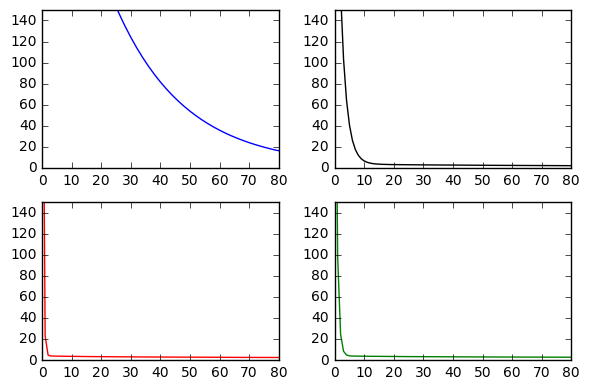

In [49]:
alpha_graph(X_train, y_train, regularized = True)

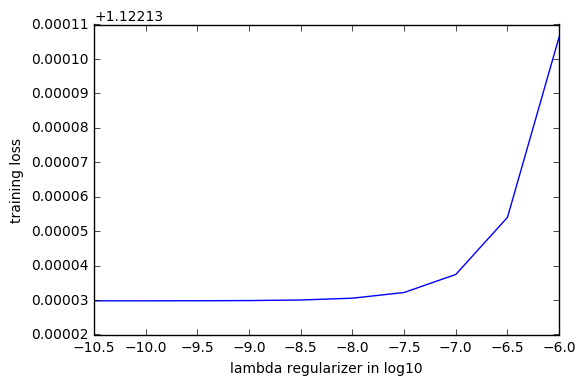

In [50]:
def lambda_graph(X, y):
    l = []
    expo = [-6-i/2 for i in range(10)]
    lambda_ = [ 10**e for e in expo] 
    lambda_plot = [np.log10(x) for x in lambda_]
    
    for lamb in lambda_:
        loss_hist, theta_hist = regularized_grad_descent(X, y, lambda_reg = lamb)
        l.append(loss_hist[-1])

    plt.plot(lambda_plot, l)
    plt.xlabel('lambda regularizer in log10')
    plt.ylabel('training loss')
    plt.show()
    
lambda_graph(X_train, y_train)

In [51]:
def stochastic_grad_descent(X, y, alpha=0.1, lambda_reg=10e-7, num_iter=1000, l_search = True):
    """
    In this question you will implement stochastic gradient descent with a regularization term
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - string or float. step size in gradient descent
                NOTE: In SGD, it's not always a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every iteration is alpha.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t)
                if alpha == "1/t", alpha = 1/t
        lambda_reg - the regularization coefficient
        num_iter - number of epochs (i.e number of times) to go through the whole training set
    
    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size (num_iter, num_instances, num_features) 
        loss hist - the history of regularized loss function vector, 2D numpy array of size(num_iter, num_instances)
    """
    (num_instances, num_features) = X.shape
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter) #initialize loss_hist
    a_hist = [alpha]
    
    s = [i for i in range(num_instances)]
    
    for i in range(num_iter):
        S = np.random.permutation(s)
        loss = r_sq_loss(theta, X, y, lambda_reg)
        loss_hist[i] = loss
        
        if i != 0:
            if loss/loss_hist[i-1] >= 0.99999:
                return(loss_hist[0:i], theta_hist[0:i, :])
            if loss >= loss_hist[i-1]:
                raise Exception('not converging')
        
        theta_hist[i] = theta
        
        if i != 0 and loss >= loss_hist[i-1]:
            #print(a_hist)
            return(loss_hist[0:i], theta_hist[0:i, :])
        
        gradient = np.array( num_features )
        
        for j in S:
            pred = np.dot(theta, X[j])
            residual = pred-y[j] 
            gradient = np.dot(residual, X[j]) /num_features
            theta -= alpha * gradient
        
        if l_search:
            alpha= backtrack_line_search(loss, gradient, X, y, theta, alpha)
            a_hist.append(round(alpha,4))
        
    return loss_hist, theta_hist

loss_hist, theta_hist = stochastic_grad_descent(X_train, y_train, alpha = 0.02, num_iter=100)
loss_hist[-1]

2.6168126285780824